In [1]:
# The MIT License (MIT) Copyright (c) 2023 Emilio Morales
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of 
# this software and associated documentation files (the "Software"), to deal in the Software without 
# restriction, including without limitation the rights to use, copy, modify, merge, publish, 
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the 
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or 
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES 
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN 
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/milmor/NLP/blob/main/Notebooks/12_RNN_LSTM.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

# Redes neuronales recurrentes
  
- Dataset: https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification

In [2]:
import torch
import pandas as pd

torch.__version__

'2.0.1+cu117'

In [3]:
torch.manual_seed(77)

## 1.- Conjuntos de entrenamiento y validación

In [4]:
df = pd.read_csv('./cyberbullying_tweets.csv')   

In [5]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [6]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [7]:
# Contar elementos por clase
count = df['cyberbullying_type'].value_counts()
count

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

In [8]:
# Creamos un diccionario que mapea cada etiqueta a un número entero
labels_dict = {
    'not_cyberbullying': 0,
    'gender': 1,
    'religion': 2,
    'other_cyberbullying': 3,
    'age': 4,
    'ethnicity': 5
}

df['cyberbullying_type'] = df['cyberbullying_type'].replace(labels_dict)
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0
4,@RudhoeEnglish This is an ISIS account pretend...,0


- Elimina puntuación y convierte a minúsculas
- Se utiliza el método __str.translate()__ para eliminar todos los caracteres de puntuación mediante una tabla de traducción creada con el método __str.maketrans__. La constante string.punctuation contiene todos los caracteres de puntuación ASCII, que se eliminan de los valores en la columna

In [9]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
df['tweet_text'] = df['tweet_text'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
df.head()

,tweet_text,cyberbullying_type
0,in other words katandandre your food was crapi...,0
1,why is aussietv so white mkr theblock imaceleb...,0
2,xochitlsuckkks a classy whore or more red velv...,0
3,jasongio meh p thanks for the heads up but no...,0
4,rudhoeenglish this is an isis account pretendi...,0


In [11]:
from sklearn.model_selection import train_test_split
train_df, val_df= train_test_split(df, test_size = 0.15, random_state = 123)

In [12]:
train_df['cyberbullying_type'].value_counts()

cyberbullying_type
0    6826
1    6821
5    6777
4    6763
2    6743
3    6608
Name: count, dtype: int64

## 2.- Pipeline

- Crea vocabulario y define tokenizer.

In [13]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab as Vocab
from collections import Counter

In [14]:
tokenizer = get_tokenizer('basic_english')

In [15]:
def build_vocab(text, tokenizer, min_freq=5):
    counter = Counter()
    for string_ in text:
        counter.update(tokenizer(string_))
    return Vocab(counter, min_freq=min_freq,
                 specials=['<unk>', '<pad>'])


vocab = build_vocab(train_df.tweet_text.values, tokenizer, 5)

In [16]:
vocab_size = len(vocab) + 1
vocab_size

9952

In [17]:
vocab.set_default_index(len(vocab)) # evita error <ukn>

In [18]:
maxlen = 64

def data_process(df):
    data = []
    for raw_txt, target in zip(df.tweet_text.values, df.cyberbullying_type.values):
        tensor_ = torch.tensor([vocab[token] for token in tokenizer(raw_txt)],
                        dtype=torch.long)
        if tensor_.shape[0] <= maxlen:
            # int64 to avoid CrossEntropyLoss expected scalar type Long but found Float
            target_ = torch.tensor(target, dtype=torch.int64)
            data.append((tensor_, target_))
    return data

train_data = data_process(train_df)
val_data = data_process(val_df)
len(train_data), len(val_data)

(40523, 7149)

In [19]:
batch_size = 64
PAD_IDX = vocab['<pad>']

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def generate_batch(data_batch):
    x, y = [], []
    for (x_item, y_item) in data_batch:
        x.append(x_item)
        y.append(y_item)

    x = pad_sequence(x, batch_first=True, padding_value=PAD_IDX)
    # int64 to avoid CrossEntropyLoss expected scalar type Long but found Float
    y = torch.tensor(y, dtype=torch.int64) 
    return x, y


train_loader = DataLoader(train_data, batch_size=batch_size,
                          shuffle=True, collate_fn=generate_batch, 
                          num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=batch_size,
                        shuffle=True, collate_fn=generate_batch,
                        num_workers=4, pin_memory=True)

In [20]:
%%timeit
train_batch, target_batch = next(iter(train_loader))

100 ms ± 3.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
train_batch, target_batch = next(iter(train_loader))

In [22]:
train_batch.shape, target_batch.shape

(torch.Size([64, 63]), torch.Size([64]))

## 3.- Modelo

### RNN simple

RNN:
\begin{equation}
h_t = f(Wx_t + Uh_{t-1} + b)
\end{equation}

In [23]:
import torch.nn as nn
from torch import optim
import time

In [24]:
class RNN(nn.Module):
    def __init__(self, vocab_size):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 128)
        self.rnn = nn.RNN(input_size=128, 
                        hidden_size=128, 
                        num_layers=1, 
                        batch_first=True)
        self.fc1 = nn.Linear(128, 16)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(16, 16)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(16, 6)
        
    def forward(self, x):
        x = self.embedding(x)
        x, hidden = self.rnn(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

rnn = RNN(vocab_size)
output_batch = rnn(train_batch)
output_batch.shape

torch.Size([64, 6])

### LSTM

LSTM:

\begin{align}
i_t & = \sigma(W^ix_t + U^ih_{t-1} + b^i) \\
f_t & = \sigma(W^fx_t + U^fh_{t-1} + b^f) \\
o_t & = \sigma(W^ox_t + U^oh_{t-1} + b^o) \\
g_t & = \text{tanh}(W^gx_t + U^gh_{t-1} + b^g) \\
c_t & = f_t \odot c_{t-1} + i_t \odot g_t\\
h_t & = o_t \odot \text{tanh}(c_t) \\
\end{align}

In [25]:
class LSTM(nn.Module):
    def __init__(self, vocab_size):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 128)
        self.lstm = nn.LSTM(input_size=128, 
                        hidden_size=128, 
                        num_layers=1, 
                        batch_first=True)
        self.fc1 = nn.Linear(128, 16)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(16, 16)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(16, 6)
        
    def forward(self, x):
        x = self.embedding(x)
        x, (hidden, cell) = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

lstm = LSTM(vocab_size)
output_batch = lstm(train_batch)
output_batch.shape

torch.Size([64, 6])

## 4.- Entrenamiento

In [26]:
loss_fn = torch.nn.CrossEntropyLoss()

In [27]:
def train(model, device, train_loader, optimizer, epoch):
    start = time.time()
    running_loss = 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'\nTime for epoch {epoch} is {time.time()-start:.4f} sec Train loss: {running_loss / len(train_loader):.4f}')

In [28]:
def test(model, device, test_loader):
    start = time.time()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            outputs = outputs.squeeze()
            loss = loss_fn(outputs, labels)
            _, pred = torch.max(outputs.data, 1)
            running_acc += (pred == labels).sum().item()
            running_loss += loss.item()

    print(f'Time for eval is {time.time()-start:.4f} sec Val loss: {running_loss / len(test_loader):.4f}')
    print(f'Val acc: {running_acc / len(test_loader.dataset):.4f}')

In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [30]:
rnn.to(device)

rnn_optimizer = optim.Adam(rnn.parameters(), lr=0.001)

In [31]:
epochs = 7

for epoch in range(epochs):
    train(rnn, device, train_loader, rnn_optimizer, epoch)
    test(rnn, device, val_loader)


Time for epoch 0 is 1.3425 sec Train loss: 1.7842
Time for eval is 0.1950 sec Val loss: 1.7790
Val acc: 0.1832

Time for epoch 1 is 1.1255 sec Train loss: 1.7779
Time for eval is 0.2087 sec Val loss: 1.7786
Val acc: 0.1733

Time for epoch 2 is 1.1304 sec Train loss: 1.7778
Time for eval is 0.2124 sec Val loss: 1.7846
Val acc: 0.1802

Time for epoch 3 is 1.1561 sec Train loss: 1.7799
Time for eval is 0.2118 sec Val loss: 1.7819
Val acc: 0.1691

Time for epoch 4 is 1.1714 sec Train loss: 1.7803
Time for eval is 0.1974 sec Val loss: 1.7836
Val acc: 0.1690

Time for epoch 5 is 1.1234 sec Train loss: 1.7788
Time for eval is 0.1916 sec Val loss: 1.7751
Val acc: 0.1760

Time for epoch 6 is 1.1662 sec Train loss: 1.7762
Time for eval is 0.2195 sec Val loss: 1.7732
Val acc: 0.1792


In [32]:
lstm.to(device)

lstm_optimizer = optim.Adam(lstm.parameters(), lr=0.001)

In [33]:
epochs = 7

for epoch in range(epochs):
    train(lstm, device, train_loader, lstm_optimizer, epoch)
    test(lstm, device, val_loader)


Time for epoch 0 is 1.2136 sec Train loss: 1.1931
Time for eval is 0.2197 sec Val loss: 0.6679
Val acc: 0.7200

Time for epoch 1 is 1.2065 sec Train loss: 0.5581
Time for eval is 0.2225 sec Val loss: 0.4787
Val acc: 0.7941

Time for epoch 2 is 1.1955 sec Train loss: 0.4383
Time for eval is 0.2015 sec Val loss: 0.4402
Val acc: 0.8151

Time for epoch 3 is 1.1987 sec Train loss: 0.3746
Time for eval is 0.1989 sec Val loss: 0.4385
Val acc: 0.8190

Time for epoch 4 is 1.1982 sec Train loss: 0.3276
Time for eval is 0.2161 sec Val loss: 0.4265
Val acc: 0.8226

Time for epoch 5 is 1.1883 sec Train loss: 0.2892
Time for eval is 0.1954 sec Val loss: 0.4377
Val acc: 0.8214

Time for epoch 6 is 1.2393 sec Train loss: 0.2503
Time for eval is 0.2052 sec Val loss: 0.4718
Val acc: 0.8243


## 5.- Vectores

In [34]:
words = 'bad good hate happy love scared friend sad alive family confident fight live funny best great amazing'
words_ids = torch.tensor([vocab[token] for token in tokenizer(words)])
words_ids

tensor([ 588,  248,  493, 1192,  820, 3232,  731, 1844,  788,  593, 5176,  749,
        1171,  269,  604, 1692, 2801])

In [35]:
lstm.to('cpu')
lstm.eval()

LSTM(
  (embedding): Embedding(9952, 128)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=16, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=6, bias=True)
)

In [36]:
embeddings = lstm.embedding(words_ids).detach()
embeddings.shape

torch.Size([17, 128])

- Visualización de los vectores aprendidos

(17, 2)


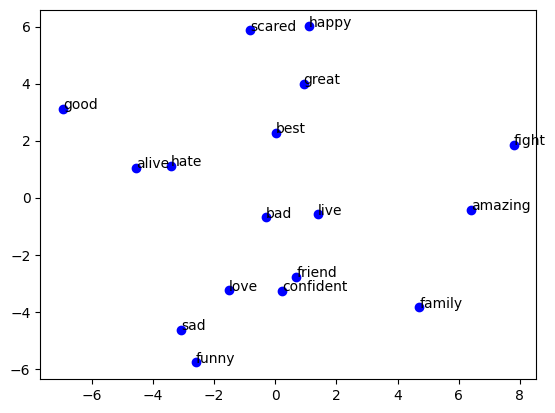

In [37]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Perform PCA on embeddings
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)
print(pca_embeddings.shape)

# Plot embeddings using matplotlib
fig, ax = plt.subplots()
ax.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], marker='o', c='b')

for i, word in enumerate(words.split()):
    ax.annotate(word, (pca_embeddings[i, 0], pca_embeddings[i, 1]))
    
plt.show()